<font size=6><b>Определение стоимости автомобилей</b></font>

---

<font size=5><b>Описание проекта</b></font>

<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">
    
<b>Цель</b>: Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. Необходимо построить модель, которая умеет её определять. Критерии, которые важны заказчику: качество предсказания, время обучения модели, время предсказания модели.<br><br>
<b>Данные</b>: Набор данных находится в файле */datasets/autos.csv*. Данные о технических характеристиках, комплектации и ценах других автомобилей. Целевой признак: цена автомобиля (евро).<br><br>
<b>Содержание</b>:   
1. Загрузка данных.  
1. Изучение данных.  
1. Подготовка выборок для обучения.  
1. Обучение моделей.  
1. Анализ моделей.  
1. Проверка лучшей модели.  
1. Выводы.

## 1. Загрузка данных

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import clear_output
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
import lightgbm as lgb

RSTATE = 10101
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('autos.csv')

In [3]:
display(f'Размеры датасета: {df.shape}')
display(df.info())
display(df.head())

'Размеры датасета: (354369, 16)'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Набор данных содержит 354369 объектов по 16 признаков. В данных есть пропуски. Типы: int и object.

## 2. Изучение данных

In [4]:
df1 = df.copy()

Преобразуем даты в формат даты для дальнейшего изучения.

In [5]:
df1['DateCrawled'] = pd.to_datetime(df1['DateCrawled'])#.astype(np.int64)
df1['DateCreated'] = pd.to_datetime(df1['DateCreated'])#.astype(np.int64)
df1['LastSeen'] = pd.to_datetime(df1['LastSeen'])#.astype(np.int64)

Рассмотрим, какие года и месяцы присутствуют в датах.

In [6]:
print(f'DateCrawled: годы {df1["DateCrawled"].dt.year.unique()}, месяцы {df1["DateCrawled"].dt.month.unique()}')
print(f'DateCreated: годы {df1["DateCreated"].dt.year.unique()}, месяцы {df1["DateCreated"].dt.month.unique()}')
print(f'LastSeen: годы {df1["LastSeen"].dt.year.unique()}, месяцы {df1["LastSeen"].dt.month.unique()}')

DateCrawled: годы [2016], месяцы [3 4]
DateCreated: годы [2016 2015 2014], месяцы [ 3  4  2  1 11 12  9  8  6]
LastSeen: годы [2016], месяцы [4 3]


<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Выделим, как отдельные признаки: 
* месяц (3, 4) для **DateCrawled** и **LastSeen**;
* год (2014, 2015, 2016) для **DateCreated**.

А сами даты удалим.

In [7]:
df1['Year_Created'] = df1['DateCreated'].dt.year
df1['Month_Created'] = df1['DateCreated'].dt.month
df1['Month_LastSeen'] = df1['LastSeen'].dt.month
df1['Month_Crawled'] = df1['DateCrawled'].dt.month

df1 = df1.drop(['DateCreated', 'LastSeen', 'DateCrawled'], axis=1)

Построим матрицу корреляции.

In [8]:
df1.corr(numeric_only=True).style.background_gradient(vmin=-1, vmax=1, cmap='Spectral')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,Year_Created,Month_Created,Month_LastSeen,Month_Crawled
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,nan,0.076055,-0.005551,0.014367,0.149443,0.016530
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,nan,-0.003459,0.000056,-0.000728,-0.000630,-0.000845
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,nan,0.021665,0.000057,0.003290,0.020849,0.003658
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,nan,-0.007698,0.004664,-0.001820,-0.062445,-0.002671
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,nan,0.013995,0.003290,-0.002460,0.001433,-0.002319
NumberOfPictures,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,nan,1.000000,0.000591,0.010182,0.043501,0.010526
Year_Created,-0.005551,0.000056,0.000057,0.004664,0.003290,nan,0.000591,1.000000,-0.148957,-0.001727,0.002017
Month_Created,0.014367,-0.000728,0.003290,-0.001820,-0.002460,nan,0.010182,-0.148957,1.000000,0.376773,0.973855
Month_LastSeen,0.149443,-0.000630,0.020849,-0.062445,0.001433,nan,0.043501,-0.001727,0.376773,1.000000,0.386354


Удалим все даты, как неинформативные признаки.

### 2.1 Удаление неинформативных признаков

<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Признак **NumberOfPictures** содержит только нули, поэтому удалим его.

Month_Crawled и Month_Created очень сильно коррелируют между собой, поэтому удалим признак **Month_Crawled**. Month_LastSeen также коррелирует с другими датами, однако, оставим его.

Также удалим **PostalCode**: этот признак не несёт важной информации и слабо коррелирует с целевым признаком.

In [9]:
df1 = df1.drop(['RegistrationYear', 
                'RegistrationMonth', 
                'Year_Created', 
                'Month_Created', 
                'Month_LastSeen', 
                'Month_Crawled',
                'NumberOfPictures',
                'PostalCode'
               ], 
               axis=1
              )

### 2.2 Обработка пропусков

In [10]:
print(f'Доля пропусков по признакам(%):\n{(df1.isna().sum() / len(df1) * 100).round(2).sort_values(ascending=False)}')

Доля пропусков по признакам(%):
Repaired       20.08
VehicleType    10.58
FuelType        9.28
Gearbox         5.60
Model           5.56
Price           0.00
Power           0.00
Kilometer       0.00
Brand           0.00
dtype: float64


Пропуски обнаружены в признаках: Repaired, VehicleType, FuelType, Gearbox, Model.<br>

Создадим числовой бинарный признак `Repaired_bin` и исследуем его корреляцию с другими признаками.

In [11]:
df1['Repaired_bin'] = df1['Repaired'].map({'yes': 1, 'no': 0})
print(df1.corr(numeric_only=True)['Repaired_bin'])
df1 = df1.drop('Repaired_bin', axis=1)

Price          -0.242167
Power          -0.031302
Kilometer       0.087478
Repaired_bin    1.000000
Name: Repaired_bin, dtype: float64


<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Так как пропусков много и признак `Repaired` важен, то попробуем заполнить их, исходя из других признаков `Brand` & `Model` & `VehicleType` etc.

In [12]:
# функция возвращает самое частое значение типа коробки передач для данного типа объектов
# проверка на тип и модель автомобиля
def get_filling(row, grouped):
    if row['Model'] in grouped[row['Brand']]:
        if row['VehicleType'] in grouped[row['Brand']][row['Model']]:
            return grouped[row['Brand']][row['Model']][row['VehicleType']].idxmax()
        else:
            return grouped[row['Brand']][row['Model']].idxmax()[-1]
    else:
        return grouped[row['Brand']].idxmax()[-1]

# vehicle type filling
def get_filling1(row, grouped):
    if row['Model'] in grouped[row['Brand']]:
        return grouped[row['Brand']][row['Model']].idxmax()
    else:
        return grouped[row['Brand']].idxmax()[-1]

# model filling
def get_filling2(row, grouped):
    if row['VehicleType'] in grouped[row['Brand']]:
        if row['FuelType'] in grouped[row['Brand']][row['VehicleType']]:
            return grouped[row['Brand']][row['VehicleType']][row['FuelType']].idxmax()
        else:
            return grouped[row['Brand']][row['VehicleType']].idxmax()[-1]
    else:
        return grouped[row['Brand']].idxmax()[-1]

Заполним пропуски (кроме бренда "sonstige_autos" - там много пропусков в других признаках).

In [13]:
# Ремонт
repaired_group = df.groupby(['Brand', 'Model', 'VehicleType'])['Repaired'].value_counts()
# заполнение пропусков
repaired_na_mask = (df1['Repaired'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[repaired_na_mask, 'Repaired'] = df1[repaired_na_mask].apply(get_filling, grouped=repaired_group, axis=1)
print(f'Repaired: было заполнено {df["Repaired"].isna().sum() - df1["Repaired"].isna().sum()} пропущенных значений.')

# Тип коробки передач
gearbox_group = df.groupby(['Brand', 'Model', 'VehicleType'])['Gearbox'].value_counts()
# заполнение пропусков
gearbox_na_mask = (df1['Gearbox'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[gearbox_na_mask, 'Gearbox'] = df1[gearbox_na_mask].apply(get_filling, grouped=gearbox_group, axis=1)
print(f'Gearbox: было заполнено {df["Gearbox"].isna().sum() - df1["Gearbox"].isna().sum()} пропущенных значений.')

# Тип топлива
fueltype_group = df.groupby(['Brand', 'Model', 'VehicleType'])['FuelType'].value_counts()
# заполнение пропусков
fueltype_na_mask = (df1['FuelType'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[fueltype_na_mask, 'FuelType'] = df1[fueltype_na_mask].apply(get_filling, grouped=fueltype_group, axis=1)
print(f'FuelType: было заполнено {df["FuelType"].isna().sum() - df1["FuelType"].isna().sum()} пропущенных значений.')

# Тип автомобиля
vehicletype_group = df.groupby(['Brand', 'Model'])['VehicleType'].value_counts()
# заполнение пропусков
vehicletype_na_mask = (df1['VehicleType'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[vehicletype_na_mask, 'VehicleType'] = df1[vehicletype_na_mask].apply(get_filling1, grouped=vehicletype_group, axis=1)
print(f'VehicleType: было заполнено {df["VehicleType"].isna().sum() - df1["VehicleType"].isna().sum()} пропущенных значений.')

# модель автомобиля
model_group = df.groupby(['Brand', 'VehicleType', 'FuelType'])['Model'].value_counts()
# заполнение пропусков
model_na_mask = (df1['Model'].isna()) & (df1['Brand'] != 'sonstige_autos')
df1.loc[model_na_mask, 'Model'] = df1[model_na_mask].apply(get_filling2, grouped=model_group, axis=1)
print(f'Model: было заполнено {df["Model"].isna().sum() - df1["Model"].isna().sum()} пропущенных значений.')

Repaired: было заполнено 69831 пропущенных значений.
Gearbox: было заполнено 18730 пропущенных значений.
FuelType: было заполнено 31791 пропущенных значений.
VehicleType: было заполнено 36449 пропущенных значений.
Model: было заполнено 16331 пропущенных значений.


Удалим оставшиеся пропуски.

In [14]:
df1 = df1.dropna()
print(f'Итоговое количество пропусков: {df1.isna().sum().sum()}')
print(f'Доля удалённых объектов с пропусками: {(df.shape[0] - df1.shape[0]) / df.shape[0]:.1%}')

Итоговое количество пропусков: 0
Доля удалённых объектов с пропусками: 1.0%


### 2.3 Обработка аномалий

In [16]:
df1.describe()

,Price,Power,Kilometer
count,350995.000000,350995.000000,350995.000000
mean,4410.798795,110.267585,128574.310175
std,4503.345959,189.080453,37470.436390
min,0.000000,0.000000,5000.000000
25%,1099.000000,69.000000,125000.000000
50%,2700.000000,105.000000,150000.000000
75%,6399.000000,142.000000,150000.000000
max,20000.000000,20000.000000,150000.000000


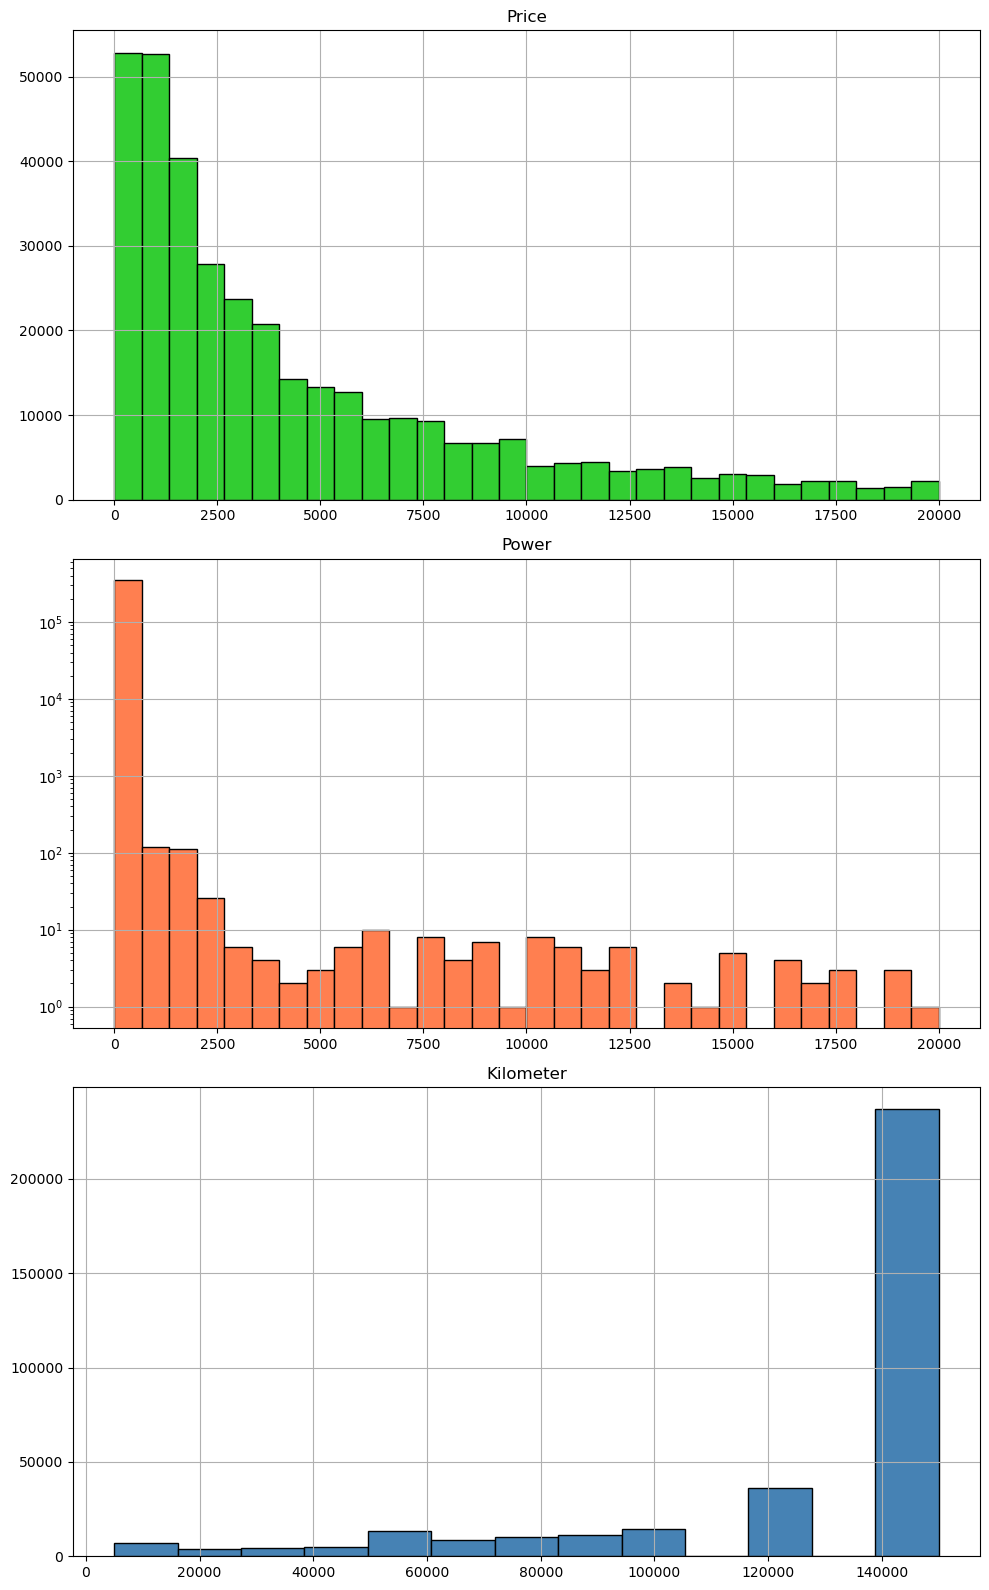

In [43]:
numeric_columns = df1.select_dtypes(int).columns
col_bins = [30, 30, 13]
col_color = ['limegreen', 'coral', 'steelblue']
is_log = [False, True, False]
fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(10, 16))
for i, ax in enumerate(axes):
    df1[numeric_columns[i]].hist(bins=col_bins[i], color=col_color[i], log=is_log[i], edgecolor='black', ax=ax)
    ax.set_title(numeric_columns[i])
plt.tight_layout()
plt.show()

#### 2.3.1 Power

Количество объектов со слишком большой мощностью двигателя: 0.00%


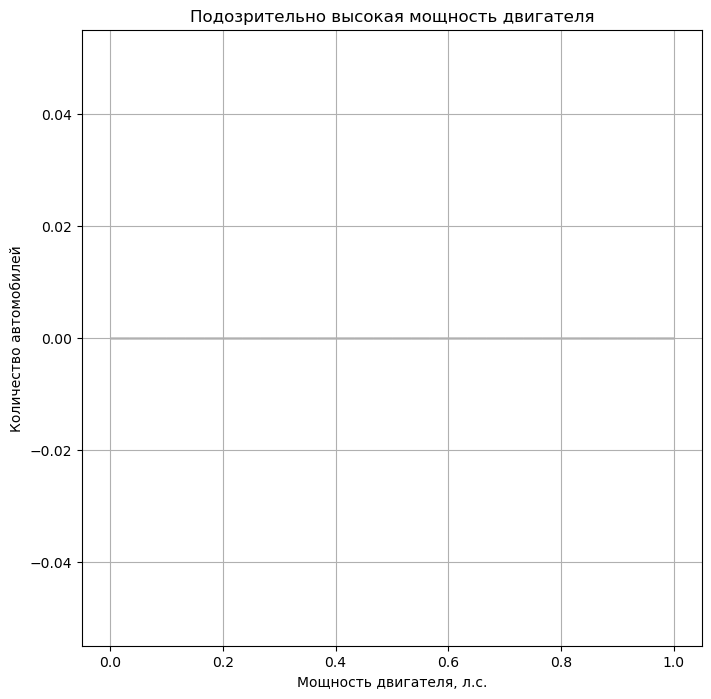

In [50]:
reg_power_mask = (df1['Power'] > 1000)
print(f'Количество объектов со слишком большой мощностью двигателя: {reg_power_mask.sum() / len(df1):.2%}')
df1[reg_power_mask]['Power'].hist(bins=30, edgecolor='black', figsize=(8, 8))
plt.title('Подозрительно высокая мощность двигателя')
plt.xlabel('Мощность двигателя, л.с.')
plt.ylabel('Количество автомобилей');

<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Вероятно, аномалии в мощности двигателя связаны с ошибкой в конвертации или вводе данных. Мощности у некоторых автомобилей увеличены в 10-100 раз. Но этих объектов очень мало (0.08%), поэтому просто удалим их.

In [47]:
df1 = df1.drop(df1[reg_power_mask].index)

<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

В данных много объектов с мощностью равной нулю. Пользователи, вероятно, забыли заполнить это поле и по умолчанию оно стало нулём. Его можно заполнить так же, как пропущенные значения.

In [48]:
reg_power0_mask = (df1['Power'] == 0)
print(f'Количество объектов с нулевой мощностью двигателя: {reg_power0_mask.sum() / len(df1):.2%}')
df1[reg_power0_mask].head(3)

Количество объектов с нулевой мощностью двигателя: 11.07%


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,manual,0,golf,150000,petrol,volkswagen,no
15,450,small,manual,0,ka,5000,petrol,ford,no
32,245,sedan,manual,0,golf,150000,petrol,volkswagen,no


Подберём для них значение мощности по соответствующим значениям других признаков.

In [49]:
power_group = df1.groupby(['Brand', 'Model', 'VehicleType', 'FuelType'])['Power'].mean()

# функция возвращает среднее значение мощности для данного типа объектов
# проверка на тип и модель автомобиля + тип топлива
def get_power(row):
    if row['Model'] in power_group[row['Brand']]:
        if row['VehicleType'] in power_group[row['Brand']][row['Model']]:
            if row['FuelType'] in power_group[row['Brand']][row['Model']][row['VehicleType']]:
                return power_group[row['Brand']][row['Model']][row['VehicleType']][row['FuelType']]
            else:
                return power_group[row['Brand']][row['Model']][row['VehicleType']].mean()
        else:
            return power_group[row['Brand']][row['Model']].mean()
    else:
        return power_group[row['Brand']].mean()

df1.loc[reg_power0_mask, 'Power'] = df1[reg_power0_mask].apply(get_power, axis=1).astype(int)

Удалим оставшиеся необработанными значения.

In [51]:
df1 = df1.drop(df1[df1['Power'] == 0].index)

#### 2.3.2 Price

В наборе данных присутствуют автомобили с нулевой ценой. Рассмотрим этот случай подробнее.

In [52]:
reg_price0_mask = (df1['Price'] == 0)
print(f'Количество объектов со нулевой ценой двигателя: {reg_price0_mask.sum() / len(df1):.2%}')
df1[reg_price0_mask].head(3)

Количество объектов со нулевой ценой двигателя: 2.91%


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,manual,50,other,40000,petrol,volkswagen,no
40,0,small,manual,56,corsa,150000,petrol,opel,no
111,0,sedan,manual,92,golf,5000,petrol,volkswagen,no


<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Так как количество таких объектов невелико (2.82%), а обучать на нулевых значениях не имеет смысла, то просто удалим из набора эти объекты, чтобы не смещать прогноз.

In [53]:
df1 = df1[df1['Price'] != 0]

Рассмотрим структуру цен на гистограмме.

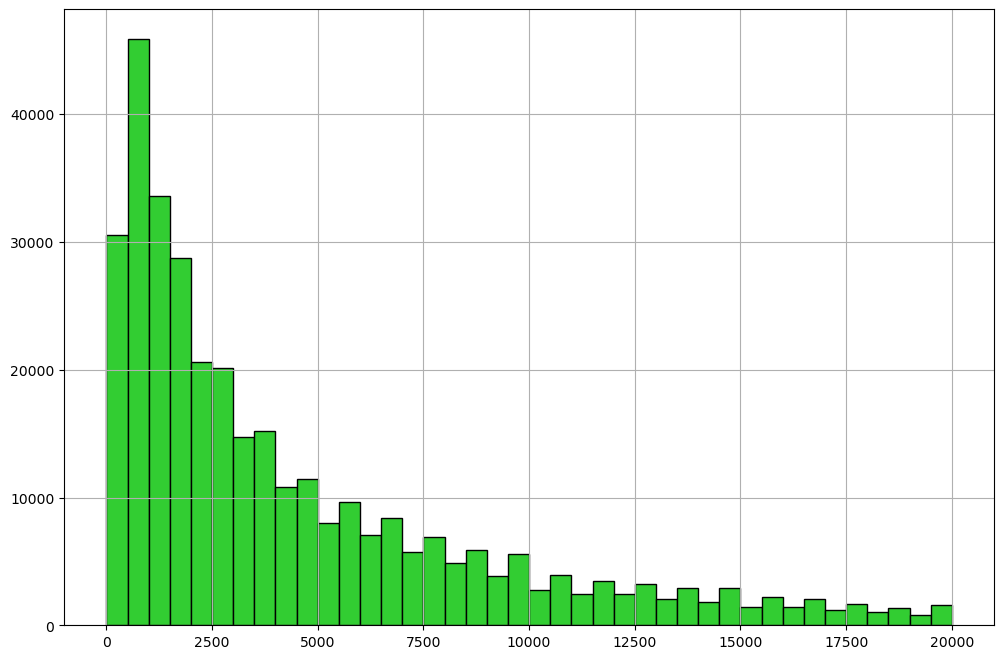

In [55]:
df1['Price'].hist(bins=40, color='limegreen', edgecolor='black', figsize=(12, 8));

### 2.4 Выводы 1

In [56]:
print('Результаты предобработки данных:')
print(f'Размер выборки: {df1.shape}')
print(f'Удалено объектов: {len(df) - len(df1)} ({(len(df) - len(df1)) / len(df):.2%})')
print(f'Количество пропусков в данных: {df1.isna().sum().sum()}')

Результаты предобработки данных:
Размер выборки: (340259, 9)
Удалено объектов: 14110 (3.98%)
Количество пропусков в данных: 0


<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Данные имеют не самое лучшее качество. Особенно информация о ремонте автомобилей, которая может сильно влиять на цену. Возможно, следует улучшить сбор данных от пользователей с целью уменьшения количества пропусков и некорректно введённой информации.

## 3. Подготовка выборок для обучения

Так как "petrol" и "gasoline" - это по своей сути одно и то же, то приведём это к одному значению.

In [57]:
df1.loc[df1['FuelType'] == 'petrol', 'FuelType'] = 'gasoline'

In [58]:
df1['FuelType'].unique()

array(['gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

### 3.1 Разделение выборки

Разделим выборку на три части: обучающая, тестовая, валидационная - 3:1:1.

In [59]:
features = df1.drop('Price', axis=1)
target = df1['Price']

X_train_valid, X_test, y_train_valid, y_test = train_test_split(features, target, 
                                                                test_size=0.2, 
                                                                shuffle=True, 
                                                                random_state=RSTATE)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, 
                                                      test_size=0.25, 
                                                      shuffle=True, 
                                                      random_state=RSTATE)
print(f'Train features: {X_train.shape}')
print(f'Valid features: {X_valid.shape}')
print(f'Test  features: {X_test.shape}')
print(f'Train target:   {y_train.shape}')
print(f'Valid  target:  {y_valid.shape}')
print(f'Test  target:   {y_test.shape}')

Train features: (204155, 8)
Valid features: (68052, 8)
Test  features: (68052, 8)
Train target:   (204155,)
Valid  target:  (68052,)
Test  target:   (68052,)


### 3.2 Подготовка признаков

#### 3.2.1 Ординальные признаки

Признаки ниже было решено кодироваль ординально, чтобы не "раздувать" в ширину набор данных для обучения.

In [60]:
ord_features = ['Brand', 'Model', 'VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Kilometer']
ord_features_ord = list(map(lambda x: x + '_ord', ord_features))

# определим категории для ординального кодирования
ord_cats = []
for feat in ord_features:
    if feat == 'Kilometer':
        ord_cats.append(np.arange(0, df1[feat].max() + 1, df1[feat].min()))
    else:
        ord_cats.append(df1[feat].unique())

# кодирование ординальных признаков
ord_encode = OrdinalEncoder(categories=ord_cats)
#ord_encode = OrdinalEncoder()
X_train[ord_features_ord] = ord_encode.fit_transform(X_train[ord_features])
X_valid[ord_features_ord] = ord_encode.transform(X_valid[ord_features])
X_test[ord_features_ord]  = ord_encode.transform(X_test[ord_features])

X_train = X_train.drop(ord_features, axis=1)
X_valid = X_valid.drop(ord_features, axis=1)
X_test  = X_test.drop(ord_features, axis=1)

In [61]:
print(f'Train features: {X_train.shape}')
print(f'Valid features: {X_valid.shape}')
print(f'Test features:  {X_test.shape}')

Train features: (204155, 8)
Valid features: (68052, 8)
Test features:  (68052, 8)


## 4. Обучение моделей

### 4.1 Простые модели

Сначала обучим для сравнения простые модели (решающее дерево и случайный лес) на кросс-валидации и подберём параметры.

In [62]:
# объединённая выборка для кросс-валидации
X_cv = pd.concat([X_train, X_valid])
y_cv = pd.concat([y_train, y_valid])

In [63]:
dtree_params = {'max_depth': range(1, 21)}

dtree_cv = GridSearchCV(estimator=DecisionTreeRegressor(random_state=RSTATE),
                        param_grid=dtree_params,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,
                        cv=3
                       )

dtree_cv.fit(X_cv, y_cv)

print(f'Решающее дерево: параметры = {dtree_cv.best_params_} RMSE = {-dtree_cv.best_score_}')

Решающее дерево: параметры = {'max_depth': 17} RMSE = 2525.60279792983


In [64]:
rforest_params = {'max_depth': [5, 10, 20],
                  'n_estimators': [100, 200]
                 }

rforest_cv = GridSearchCV(estimator=RandomForestRegressor(random_state=RSTATE, n_jobs=-1),
                          param_grid=rforest_params,
                          scoring='neg_root_mean_squared_error',
                          n_jobs=-1,
                          cv=3
                         )

rforest_cv.fit(X_cv, y_cv)

print(f'Случайный лес: параметры = {rforest_cv.best_params_} RMSE = {-rforest_cv.best_score_}')

Случайный лес: параметры = {'max_depth': 20, 'n_estimators': 200} RMSE = 2263.940008559657


### 4.2 LightGBM

Теперь обучим модель LightGBM на кросс-валидации с подбором параметров.

In [65]:
lgb_params = {'n_estimators': [100, 200],
              'max_depth': [5, 10, 20],
              'learning_rate': np.arange(0.1, 0.51, 0.1)
             }

lgb_cv = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=RSTATE, n_jobs=-1),
                      param_grid=lgb_params,
                      scoring='neg_root_mean_squared_error',
                      n_jobs=-1,
                      cv=3
                     )

lgb_cv.fit(X_cv, y_cv)
        
print(f'LightGBM: параметры = {lgb_cv.best_params_} RMSE = {-lgb_cv.best_score_}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 272207, number of used features: 8
[LightGBM] [Info] Start training from score 4546.074271
LightGBM: параметры = {'learning_rate': 0.5, 'max_depth': 20, 'n_estimators': 200} RMSE = 2255.103447743386


## 5. Анализ моделей

Сравним выбранные модели с лучшими найденными параметрами на соответствие критериям заказчика.

In [66]:
dtree_model = DecisionTreeRegressor(max_depth=dtree_cv.best_params_['max_depth'])
rforest_model = RandomForestRegressor(max_depth=rforest_cv.best_params_['max_depth'],
                                      n_estimators=rforest_cv.best_params_['n_estimators'],
                                      n_jobs=-1
                                     )
lgb_model = lgb.LGBMRegressor(n_estimators=lgb_cv.best_params_['n_estimators'], 
                              max_depth=lgb_cv.best_params_['max_depth'],
                              num_leaves=41,
                              learning_rate=lgb_cv.best_params_['learning_rate'],
                              random_state=RSTATE, n_jobs=-1
                             )

### 5.1 Время обучения

In [67]:
dtree_train_time = %timeit -n1 -r1 -o dtree_model.fit(X_train, y_train)
rforest_train_time = %timeit -n1 -r1 -o rforest_model.fit(X_train, y_train)
lgb_train_time = %timeit -n1 -r1 -o lgb_model.fit(X_train, y_train)

491 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
23.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 204155, number of used features: 8
[LightGBM] [Info] Start training from score 4551.733918
643 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [68]:
print(f'Решающее дерево: время обучения = {round(dtree_train_time.best, 2)} секунд')
print(f'Случайный лес:   время обучения = {round(rforest_train_time.best, 2)} секунд')
print(f'LightGBM:        время обучения = {round(lgb_train_time.best, 2)} секунд')

Решающее дерево: время обучения = 0.49 секунд
Случайный лес:   время обучения = 23.86 секунд
LightGBM:        время обучения = 0.64 секунд


### 5.2 Время предсказания

In [69]:
dtree_predict_time = %timeit -n1 -r1 -o dtree_model.predict(X_valid)
rforest_predict_time = %timeit -n1 -r1 -o rforest_model.predict(X_valid)
lgb_predict_time = %timeit -n1 -r1 -o lgb_model.predict(X_valid)

20.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.18 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
110 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [70]:
print(f'Решающее дерево: время предсказания = {round(dtree_predict_time.best, 2)} секунд')
print(f'Случайный лес:   время предсказания = {round(rforest_predict_time.best, 2)} секунд')
print(f'LightGBM:        время предсказания = {round(lgb_predict_time.best, 2)} секунд')

Решающее дерево: время предсказания = 0.02 секунд
Случайный лес:   время предсказания = 1.18 секунд
LightGBM:        время предсказания = 0.11 секунд


### 5.3 Качество моделей

С параметрами по умолчанию на кросс-валидации лучший результат показала модель LightGBM.

In [71]:
print(f'Решающее дерево: RMSE = {mean_squared_error(y_valid, dtree_model.predict(X_valid), squared=False)}')
print(f'Случайный лес:   RMSE = {mean_squared_error(y_valid, rforest_model.predict(X_valid), squared=False)}')
print(f'LightGBM:        RMSE = {mean_squared_error(y_valid, lgb_model.predict(X_valid), squared=False)}')

Решающее дерево: RMSE = 2503.789390898391
Случайный лес:   RMSE = 2242.7630210715897
LightGBM:        RMSE = 2231.6026119281814


### 5.4 Выводы 2

<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

Анализ моделей показал, что качество моделей LightGBM чуть выше чем у RandomForest, однако, RandomForest обучается и прогнозирует значительно медленнее. Качество же DecisionTree заметно ниже, чем у этих двух моделей. Исходя из требований заказчика для тестирования выбираем модель **LightGBM**.

## 6. Проверка лучшей модели

Проверим лучшую модель на тестовой выборке и оценим её качество.

In [72]:
print(f'Лучшая модель: RMSE = {mean_squared_error(y_test, lgb_model.predict(X_test), squared=False)}')

Лучшая модель: RMSE = 2219.060178459619


Оценим важность признаков в модели.

In [73]:
pd.Series(data=lgb_model.feature_importances_, index=lgb_model.feature_name_).sort_values(ascending=False)

Power              2817
Model_ord          1734
Kilometer_ord      1154
Brand_ord          1152
VehicleType_ord     753
Gearbox_ord         237
Repaired_ord         90
FuelType_ord         63
dtype: int32

Оценим "вменяемость" модели, сравнив её dummy-моделью (среднее значение).

In [74]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_test, y_test)
print(f'Dummy-модель: RMSE = {mean_squared_error(y_test, dummy_model.predict(X_test), squared=False)}')

Dummy-модель: RMSE = 4501.023069020895


## 7. Выводы

<div style="border:solid darkcyan 2px; padding: 20px; border-radius: 10px">

1. Данные оказались не самого высокого качества: у части автомобилей отсутствуют значимые данные (мощность, ремонт), присутствует большое число аномалий. Всё это связано, вероятно, со способом ввода и обработки данных. Стоит ввести проверку вводимой информации для улучшения качества исходных данных. Часть пропущенных значений и аномалий была обработана, чтобы и сохранить данные и не ухудшить качество моделей.
2. Данные были разделены и признаки были закодированы.
3. Выбраны три модели: DecisionTree, RandomForest и LightGBM. Методом кросс-валидации были найдены лучшие параметры для них.
4. Модели были обучены, проведено их сравнение на соответствие их требованиям заказчика (время обучения, время прогнозирования, качество). Лучшая модель - **LightGBM**.
5. В лучшей модели наиболее важными признаками стали: мощность двигателя, бренд и модель автомобиля, пробег.